<a href="https://colab.research.google.com/github/max2000777/Traitement-de-la-langue-naturelle/blob/main/%5BMIDS%5D_TAL_TP_s%C3%A9ance_3_Analyse_de_sujets_latents_Maxime_BRENNAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copier ce notebook (Fichier>Enregistrer une copie dans Drive) puis travailler sur la copie.
==

# But du TP

Dans ce TP, nous allons faire de l'inférence de sujets latents.
Il s'agit de décrire un corpus de textes à l'aide d'un ensemble de sujets (à déterminer), chaque document étant plus ou moins fortement corrélé avec les différents sujets, et chaque sujet étant plus ou moins fortement corrélé avec les différents mots du vocabulaire.
Plus précisement, nous allons utiliser la bibliothèque scikit-learn pour entraîner puis analyser un modèle de type Latent Semantic Analysis (LSA) et un modèle de type Latent Dirichlet Allocation (LDA).

Nous utiliserons un jeu de données « réelles », composé de sous-titres français de la série Game of Thrones.
La première section du notebook génère aussi un jeu de données artificiel, particulièrement adapté à l'analyse par sujets latents.
Ce jeu de données permet de tester le code et de montrer ce que les différents systèmes d'analyse étudiés peuvent donner dans un cas idéal.
**Si votre code s'exécute sans erreur mais que, au vu des résultats, vous n'êtes pas sûr·e de son bon fonctionnement, testez-le sur le jeu de données artificiel.**

In [1]:
#use_controlled_dataset = True
use_controlled_dataset = False

# Préparation d'un jeu de données artificiel

Pour vérifier le bon fonctionnement de nos systèmes d'analyse de sujets latents, nous allons utiliser un jeu de données artificiel, composé de textes que nous savons être issus de sujets bien distincts.

Les « sujets » utilisés ici sont les entiers de `0` à `n_artificial_topics=15`, ou, de manière équivalente, les lettres de l'alphabet de `"A"` (pour `0`) à `"O"` (pour `15`).
À chaque sujet correspond un petit nombre de mots, tous obtenus par répétition de la lettre associée au sujet (ex : « B » et « BBB » pour le sujet 1/B).
Chacun des `n_docs=40` documents est associé à un sujet `main_topic` et est constitué de `doc_length=2000` mots, chacun issu d'un sujet choisi avec une probabilité décroissante de sa distance à `main_topic`.

Par exemple, le huitième document, d'identifiant « doc_C_7 », est associé au topic 2/C : il contient beaucoup de mots en C, un peu moins de mots en B et D, un peu moins de mots en A et E, etc.

Un système d'analyse de sujet devrait être capable de retrouver au moins approximativement les différents sujets utilisés pour générer ce jeu de données artificiel.

In [2]:
if(use_controlled_dataset):
  import numpy as np

  n_docs = 40
  doc_length = 2000
  n_artificial_topics = 15

  import random

  dataset = []
  for i in range(n_docs):
    main_topic = int(i  * n_artificial_topics / n_docs)
    print(main_topic, end=", ", flush=True)

    tokens = []
    for j in range(doc_length):
      # Selects a topic for the word, likely to be main_topic, or very near.
      topic = main_topic + int(np.random.randn() * 1.5)
      while(topic < 0): topic += n_artificial_topics
      topic = topic % n_artificial_topics

      #
      letter = chr(65 + topic) # 65 corresponds to "A".
      token_length = np.floor(1 + 8 * np.power(np.random.uniform(), 2)) # Between 1 and 9; more likely to be small than large.
      token = letter * int(token_length)

      tokens.append(token)

    dataset.append({"str_id": f"doc_{chr(65+main_topic)}_{i}", "raw_text": " ".join(tokens)})
else:
  print("[controlled dataset not in use]")

[controlled dataset not in use]


In [3]:
if(use_controlled_dataset):
  print(dataset[7]["str_id"])
  print(dataset[7]["raw_text"]) # Should be composed mainly of words in C, then words in B or D, then words in A or E, etc.
else:
  print("[controlled dataset not in use]")

[controlled dataset not in use]


In [4]:
if(use_controlled_dataset):
  for episode in dataset:
    print(episode["str_id"], end=", ", flush=True)
    episode["processed_text"] = episode["raw_text"] # No preprocessing for the artificial dataset.
    episode["processed_tokens"] = episode["raw_text"].split()
else:
  print("[controlled dataset not in use]")

[controlled dataset not in use]


In [5]:
if(use_controlled_dataset):
  print(dataset[0]["str_id"])
  print()
  print(dataset[0]["processed_tokens"][:20])
  print("[…]")
  print(dataset[0]["processed_tokens"][-20:])
else:
  print("[controlled dataset not in use]")

[controlled dataset not in use]


# Préparation du jeu de données réelles

Le but de cette section est de charger les dialogues de la série Game of Thrones dans une liste `dataset` contenant un dictionaire par épisode.
Chaque épisode sera représenté par un dictionnaire indiquant, entre autres,

*   un identifiant (*str_id*) sous la forme « SxxEyy » où xx et yy indiquent respectivement le numéro de saison et d'épisode (dans la saison) de l'épisode ;
*   une liste de tokens (*processed_tokens*), qui sera par la suite convertie en vecteur numérique de type sac-de-mots (« *bag-of-words* »).

## Téléchargement et extraction du jeu de données

In [6]:
if(not use_controlled_dataset):
  import os
  import urllib # To download files.
  import zipfile # To unzip files.

  if(True): # True for French data, False for English data.
    zip_url = "https://moodle.u-paris.fr/mod/resource/view.php?id=1329463" # fr
  else:
    zip_url = "https://moodle.u-paris.fr/mod/resource/view.php?id=1330372" # en

  data_dirname = "data" # Name of the directory in which the dataset is/will be.

  if(os.path.isdir(data_dirname)):
    print("Dataset found.")
  else:
    # Downloads the dataset.
    tmp = urllib.request.urlretrieve(zip_url)
    filename = tmp[0]
    print(f"Dataset downloaded to '{filename}'.")

    # Extracts the dataset.
    with zipfile.ZipFile(filename, 'r') as zip_ref:
      zip_ref.extractall(".")
    assert os.path.isdir(data_dirname)
    print(f"Dataset extracted to '{data_dirname}'.")
else:
  print("[controlled dataset in use]")

Dataset found.


## Lecture du jeu de données

Le jeu de données contient un fichier SRT par épisode de la série Game of Thrones, groupés par saison (un sous-dossier par saison).
(La syntaxe des fichiers SRT est décrite ici : https://docs.fileformat.com/video/srt/)

Cette sous-section crée la liste `dataset` dans laquelle chaque épisode est représenté par un dictionnaire indiquant, pour l'instant, son identifiant (*str_id*) et une chaîne de caractères contenant le contenu des sous-titre de l'épisode (*raw_text*).

In [7]:
if(not use_controlled_dataset):
  dataset = [] # This will be a list of dictionaries.

  # file_path: str
  # Returns a string.
  def read_srt_file(file_path):
      lines = []
      with open(file_path) as f:
          c = True
          while(c):
              s = f.readline() # This should be the end of the file, an empty line or a number.
              if(s == ""): c = False # The end of the file has been reached.
              if(s.strip() == ""): continue # End of the file or empty line.

              f.readline() # We can throw away the timing that follows.

              # All the next non-empty lines are character lines.
              s = f.readline().strip()
              while(s != ""):
                  lines.append(s)
                  s = f.readline().strip()

      return ' '.join(lines)

  data_dirname = "data"
  for path, dirs, files in os.walk(data_dirname): # Iterates through every subdirectories.
      path_parts = path.split(os.path.sep)
      if(len(path_parts) == 1): continue # There is no subtitle file in the root directory.
      season = path_parts[1]
      #print(season)
      for file in files:
          file_parts = file.split(".")
          episode = file_parts[0]
          str_id = f"{season}-{episode}"
          print(str_id, end= ", ")

          file_path = os.path.join(path, file)
          #print(file_path)

          dataset.append({"str_id": str_id, "raw_text": read_srt_file(file_path)})
else:
  print("[controlled dataset in use]")

S01-E01, S01-E02, S01-E03, S01-E04, S01-E05, S01-E06, S01-E07, S01-E08, S01-E09, S01-E10, S02-E01, S02-E02, S02-E03, S02-E04, S02-E05, S02-E06, S02-E07, S02-E08, S02-E09, S02-E10, S03-E01, S03-E02, S03-E03, S03-E04, S03-E05, S03-E06, S03-E07, S03-E08, S03-E09, S03-E10, S04-E01, S04-E02, S04-E03, S04-E04, S04-E05, S04-E06, S04-E07, S04-E08, S04-E09, S04-E10, S05-E01, S05-E02, S05-E03, S05-E04, S05-E05, S05-E06, S05-E07, S05-E08, S05-E09, S05-E10, S06-E01, S06-E02, S06-E03, S06-E04, S06-E05, S06-E06, S06-E07, S06-E08, S06-E10, S06-S09, S07-E01, S07-E02, S07-E03, S07-E04, S07-E05, S07-E06, S07-E07, S08-E01, S08-E02, S08-E03, S08-E04, S08-E05, S08-E06, 

In [8]:
if(not use_controlled_dataset):
  dataset = sorted(dataset, key=(lambda x: x["str_id"])) # Sorts the episode chronologically (via their season and episode number).

  for episode in dataset: print(episode["str_id"], end=", ")
else:
  print("[controlled dataset in use]")

S01-E01, S01-E02, S01-E03, S01-E04, S01-E05, S01-E06, S01-E07, S01-E08, S01-E09, S01-E10, S02-E01, S02-E02, S02-E03, S02-E04, S02-E05, S02-E06, S02-E07, S02-E08, S02-E09, S02-E10, S03-E01, S03-E02, S03-E03, S03-E04, S03-E05, S03-E06, S03-E07, S03-E08, S03-E09, S03-E10, S04-E01, S04-E02, S04-E03, S04-E04, S04-E05, S04-E06, S04-E07, S04-E08, S04-E09, S04-E10, S05-E01, S05-E02, S05-E03, S05-E04, S05-E05, S05-E06, S05-E07, S05-E08, S05-E09, S05-E10, S06-E01, S06-E02, S06-E03, S06-E04, S06-E05, S06-E06, S06-E07, S06-E08, S06-E10, S06-S09, S07-E01, S07-E02, S07-E03, S07-E04, S07-E05, S07-E06, S07-E07, S08-E01, S08-E02, S08-E03, S08-E04, S08-E05, S08-E06, 

In [9]:
if(not use_controlled_dataset):
  print(f'{dataset[0]["str_id"]}:')
  print(dataset[0]["raw_text"][:200]) # Beginning of the first episode.
  print("[…]")
  print(dataset[0]["raw_text"][-200:]) # End of the first episode.
else:
  print("[controlled dataset in use]")

S01-E01:
Doucement. Que croyais-tu ? Ce sont des sauvages. L'un vole une chÃ¨vre Ã  l'autre, et ils finissent par s'Ã©triper. Je n'ai jamais vu des sauvageons faire Ã§a. Je n'ai jamais rien vu de tel, de toute
[…]
 tout va bien. - Tout va bien. - Il nous a vus ! Je t'ai entendu la premiÃ¨re fois. Tu es un vrai petit grimpeur. - Quel Ã¢ge as-tu, mon garÃ§on ? - Dix ans. Dix ans. Les choses que je fais par amour.


## Pré-traitement du texte

Cette sous-section enrichit le dictionnaire représentant chaque épisode avec, notamment, la liste de tokens (*processed_tokens*) qui sera ensuite convertie en vecteur numérique de type sac-de-mots (« *bag-of-words* »).
Cette liste est obtenue des sous-titres de l'épisode en plusieurs étapes : (i) normalisation/simplification du texte, (ii) tokenisation, (iii) filtrage des mots vides (« *stop words* », c.-à-d. les mots non pertinents pour le problème car n'ayant que peu de valeur sémantique, comme les articles « le/la/… » ou les conjonctions « mais/ou/et/donc/… »).

Le bloc suivant définit, si nécessaire, l'ensemble de mots vides à utiliser (`stopwords`).

In [10]:
if(not use_controlled_dataset):
  filter_stopwords = True
  #filter_stopwords = False

  import nltk

  if(filter_stopwords):
    try:
      print(f"NLTK stop words: {nltk.corpus.stopwords.words('french')}") # This might fail if "stopwords" is missing.
    except:
      nltk.download('stopwords')
      print(f"NLTK stop words: {nltk.corpus.stopwords.words('french')}")

    stopwords = set()
    stopwords.update(set(nltk.corpus.stopwords.words("french")))

    # Additional stop words.
    stopwords.update({"a", "si", "plus", "fait", "faire", "ça", "tout", "tous", "toute", "toutes", "ce", "celui", "ceux", "celle", "celles", "son", "sa", "ses", "leur", "leurs", "tu", "dit", "oui", "non", "si", "alors", "ne", "être", "avoir", "faut", "veux", "i", "ici", "là", "où", "quand", "veut", "peut", "il", "ils", "elle", "elles", "mais", "ou", "et", "donc", "car"})

    print(f"Stop words used: {stopwords}")
else:
  print("[controlled dataset in use]")

NLTK stop words: ['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura

Le bloc suivant s'assure de la disponibilité du modèle de tokenisation à utiliser (`nltk.word_tokenize`).

In [11]:
if(not use_controlled_dataset):
  try:
    print(nltk.word_tokenize("NLTK tokeniser ready.")) # This might fail if "punkt" is missing.
  except:
    # Modifications in 2025/01/23.
    #nltk.download('punkt') # Necessary to use nltk.word_tokenize.
    nltk.download('punkt_tab') # Necessary to use nltk.word_tokenize.

    print(nltk.word_tokenize("NLTK tokeniser ready."))
else:
  print("[controlled dataset in use]")

['NLTK', 'tokeniser', 'ready', '.']


Le bloc suivant définit, si nécessaire, le modèle de racinisation (« *stemming* ») à utiliser (`stemmer`).


In [12]:
if(not use_controlled_dataset):
  stem_words = True
  stem_words = False

  if(stem_words):
    stemmer = nltk.stem.snowball.FrenchStemmer() # https://www.nltk.org/api/nltk.stem.snowball.html
else:
  print("[controlled dataset in use]")

Le bloc suivant définit la fonction utilisée pour pré-traiter le texte de chaque épisode. C'est elle qui effectue les trois étapes, mentionnées plus haut, de normalisation/simplification, tokenisation, et filtrage.

Concernant l'étape de normalisation/simplification, la fonction doit au minimum passer tous les caractères en bas de casse et supprimer la ponctuation.

Des opérations supplémentaires sont envisageables, au sein de l'étape de normalisation/simplification, comme après la tokenisation.

In [13]:
if(not use_controlled_dataset):
  import re # For regexes. https://docs.python.org/3/library/re.html https://docs.python.org/3/howto/regex.html

  # text: str
  # Returns a pair composed of (i) a string (the text just before tokenization) and (ii) a list of tokens (i.e. strings).
  def preprocess(text):
      # (i) Normalisation/simplification step
      tmp = text
      ## TODO
      tmp = re.sub(r'[^\w\s]', ' ', tmp) # Replaces any non-alphanumeric character (\w) and non-whitespace character (\s) with a space.
      tmp = re.sub(r'[0-9]', ' ', tmp) # Replaces any numeric character with a space.
      tmp = tmp.lower() # Lower cases the string
      #tmp = re.sub(r'\s{2,}', ' ', tmp) # Replaces any duplicate spaces with a single space.
      processed_text = tmp

      # (ii) Tokenisation step
      ## TODO
      tokens = nltk.word_tokenize(processed_text)

      # (iii) Filtering step
      ## TODO
      if(filter_stopwords): tokens = [token for token in tokens if(token not in stopwords)]

      # (bonus) Stemming step
      if(stem_words): tokens = [stemmer.stem(token) for token in tokens]

      return (processed_text, tokens)

  # Test
  print(preprocess("Yo Jon Snow, comment ça ?  Plutôt bien et vous ? Comptez jusqu'à 3, s'il vous plaît. 1, 2, 3. Nickel."))
else:
  print("[controlled dataset in use]")

('yo jon snow  comment ça    plutôt bien et vous   comptez jusqu à    s il vous plaît           nickel ', ['yo', 'jon', 'snow', 'comment', 'plutôt', 'bien', 'comptez', 'jusqu', 'plaît', 'nickel'])


Le bloc suivant effectue le pré-traitement des épisodes implémenté par la fonction définie ci-dessus.

In [14]:
if(not use_controlled_dataset):
  for episode in dataset:
    print(episode["str_id"], end=", ", flush=True)

    (text, tokens) = preprocess(episode["raw_text"])
    episode["processed_text"] = text
    episode["processed_tokens"] = tokens
else:
  print("[controlled dataset in use]")

S01-E01, S01-E02, S01-E03, S01-E04, S01-E05, S01-E06, S01-E07, S01-E08, S01-E09, S01-E10, S02-E01, S02-E02, S02-E03, S02-E04, S02-E05, S02-E06, S02-E07, S02-E08, S02-E09, S02-E10, S03-E01, S03-E02, S03-E03, S03-E04, S03-E05, S03-E06, S03-E07, S03-E08, S03-E09, S03-E10, S04-E01, S04-E02, S04-E03, S04-E04, S04-E05, S04-E06, S04-E07, S04-E08, S04-E09, S04-E10, S05-E01, S05-E02, S05-E03, S05-E04, S05-E05, S05-E06, S05-E07, S05-E08, S05-E09, S05-E10, S06-E01, S06-E02, S06-E03, S06-E04, S06-E05, S06-E06, S06-E07, S06-E08, S06-E10, S06-S09, S07-E01, S07-E02, S07-E03, S07-E04, S07-E05, S07-E06, S07-E07, S08-E01, S08-E02, S08-E03, S08-E04, S08-E05, S08-E06, 

In [15]:
if(not use_controlled_dataset):
  print(dataset[0]["str_id"])
  print()
  print(dataset[0]["processed_tokens"][:20])
  print("[…]")
  print(dataset[0]["processed_tokens"][-20:])
else:
  print("[controlled dataset in use]")

S01-E01

['doucement', 'croyais', 'sauvages', 'vole', 'chã', 'vre', 'ã', 'autre', 'finissent', 'ã', 'triper', 'jamais', 'vu', 'sauvageons', 'ã', 'jamais', 'rien', 'vu', 'tel', 'vie']
[…]
['bien', 'vus', 'entendu', 'premiã', 're', 'fois', 'vrai', 'petit', 'grimpeur', 'quel', 'ã', 'ge', 'garã', 'dix', 'ans', 'dix', 'ans', 'choses', 'fais', 'amour']


In [16]:
print(dataset[0].keys())

dict_keys(['str_id', 'raw_text', 'processed_text', 'processed_tokens'])


# Création de la matrice de comptage

Le but de cette section est de créer une matrice de comptage `matrix` indiquant, pour un ensemble de formes choisies (c.-à-d. type de tokens), pour chaque document, le nombre d'occurrences de chaque forme dans le document.

Nous allons procéder en trois étapes : (i) comptage par document des formes, (ii) création d'un vocabulaire incluant ou non un forme en fonction de sa fréquence de documents (c.-à-d. la proportion d'épisodes dans lesquels elle apparaît ; le but étant de filtrer les mots trop rares et les mots trop fréquents), (iii) création de la matrice de comptage, restreinte au vocabulaire fixé.

## Comptage par document des formes

Le bloc suivant compte (i) pour chaque forme, le nombre de documents dans laquelle est apparaît, et (ii) pour chaque document, le nombre d'occurrences de chaque forme.

In [17]:
from collections import Counter # https://docs.python.org/3/library/collections.html#collections.Counter

document_form_counts = Counter() # Form each form, the number of documents it occurs in.
for episode in dataset:
    print(episode["str_id"], end=", ", flush=True)

    episode["counts"] = Counter(episode["processed_tokens"]) # For each form, the number of its occurences in the document.
    document_form_counts.update(set(episode["processed_tokens"]))
print()

print(document_form_counts)

S01-E01, S01-E02, S01-E03, S01-E04, S01-E05, S01-E06, S01-E07, S01-E08, S01-E09, S01-E10, S02-E01, S02-E02, S02-E03, S02-E04, S02-E05, S02-E06, S02-E07, S02-E08, S02-E09, S02-E10, S03-E01, S03-E02, S03-E03, S03-E04, S03-E05, S03-E06, S03-E07, S03-E08, S03-E09, S03-E10, S04-E01, S04-E02, S04-E03, S04-E04, S04-E05, S04-E06, S04-E07, S04-E08, S04-E09, S04-E10, S05-E01, S05-E02, S05-E03, S05-E04, S05-E05, S05-E06, S05-E07, S05-E08, S05-E09, S05-E10, S06-E01, S06-E02, S06-E03, S06-E04, S06-E05, S06-E06, S06-E07, S06-E08, S06-E10, S06-S09, S07-E01, S07-E02, S07-E03, S07-E04, S07-E05, S07-E06, S07-E07, S08-E01, S08-E02, S08-E03, S08-E04, S08-E05, S08-E06, 
Counter({'ã': 73, 'va': 73, 'prã': 73, 'frã': 73, 'sais': 73, 'lã': 73, 'trã': 73, 'pourquoi': 73, 'e': 73, 'mort': 73, 'nã': 73, 'dã': 73, 'roi': 73, 'rã': 72, 'hommes': 72, 'jamais': 72, 'tã': 72, 'vu': 72, 're': 72, 'ãªtes': 72, 'oã¹': 72, 'bien': 72, 'deux': 72, 'sans': 72, 'comme': 72, 'homme': 72, 'quoi': 72, 'pã': 72, 'rien': 72, 'au

In [18]:
print(dataset[0].keys())

dict_keys(['str_id', 'raw_text', 'processed_text', 'processed_tokens', 'counts'])


## Création d'un vocabulaire

Il s'agit ici de créer le vocabulaire utilisé par la suite, contenant les formes dont la fréquence de document est supérieure à une limite inférieure `min_df` et inférieure à une limite supérieure `max_df`.
Ce vocabulaire se présentera sous la forme d'un dictionnaire `form2id`, associant à chaque forme un identifiant entier, et, inversement, d'une liste `id2form`, associant à chaque entier la forme correspondante.

In [19]:
max_df = 0.9 # Upper limit for the document frequency of a form.
min_df = 0.06 # Lower limit for the document frequency of a form.

# TODO
form2id = {} # From form (str) to id (int).
id2form = [] # From id (int) to form (str).
Nb_doc=len(dataset)

for forme, comptage in document_form_counts.items():
  episode_frequence= comptage/Nb_doc
  if episode_frequence<=max_df and episode_frequence>=min_df :
    form2id[forme]=len(form2id)
    id2form.append(forme)


print(f"Number of forms: {len(id2form)}")

Number of forms: 3165


In [20]:
print(form2id)

{'dirait': 0, 'loup': 1, 'sauvages': 2, 'assez': 3, 'pense': 4, 'aller': 5, 'aucune': 6, 'cachã': 7, 'dieux': 8, 'jeune': 9, 'parie': 10, 'majestã': 11, 'lance': 12, 'aimait': 13, 'ordre': 14, 'porte': 15, 'droit': 16, 'cour': 17, 'plaira': 18, 'servi': 19, 'inquiã': 20, 'sence': 21, 'robert': 22, 'arrive': 23, 'merveilleux': 24, 'sauver': 25, 'allons': 26, 'raison': 27, 'grã': 28, 'condamne': 29, 'bons': 30, 'lit': 31, 'trouver': 32, 'enfant': 33, 'tyrion': 34, 'senter': 35, 'crypte': 36, 'daenerys': 37, 'plaisir': 38, 'laisserai': 39, 'eau': 40, 'ons': 41, 'rompu': 42, 'diront': 43, 'fiche': 44, 'piã': 45, 'mauvaise': 46, 'histoires': 47, 'vrai': 48, 'saignã': 49, 'pardon': 50, 'exã': 51, 'parmi': 52, 'moins': 53, 'jã': 54, 'vite': 55, 'blason': 56, 'fiã': 57, 'trangã': 58, 'moitiã': 59, 'tãªte': 60, 'prier': 61, 'conseil': 62, 'puissant': 63, 'chaque': 64, 'joli': 65, 'boit': 66, 'combattre': 67, 'dites': 68, 'mot': 69, 'montagnes': 70, 'prononce': 71, 'viens': 72, 'requiert': 73, '

## Création de la matrice de comptage

Créer une matrice de comptage sous forme d'un tableau Numpy bidimensionnel.
Les lignes doivent être indicées par les documents, les colonnes par les formes.

In [21]:
import numpy as np

# TODO
matrix = np.zeros((Nb_doc,len(form2id)))
print(matrix.shape)
for i  in range(0,len(dataset)):
  for forme,comptage in dataset[i]['counts'].items():
    if forme in id2form:
      matrix[i,form2id[forme]]=comptage

print(matrix)

doc_lengths = matrix.sum(axis=1) # For each document, its length.
term_frequency = matrix.sum(axis=0) # For each form, its frequency (count).

(73, 3165)
[[1. 2. 1. ... 0. 0. 0.]
 [0. 9. 0. ... 0. 0. 0.]
 [0. 2. 2. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


# Latent Semantic Analysis (LSA)

## Entraînement d'un modèle

In [22]:
%%time

from sklearn.decomposition import TruncatedSVD # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

lsa_n_topics = 15
assert lsa_n_topics <= len(dataset) # With LSA, their cannot be more topics than documents.
lsa_model = TruncatedSVD(n_components=lsa_n_topics, n_iter=10)

print("Fitting the model…", end="", flush=True)
lsa_model.fit(X=matrix)
print(" Done!")

Fitting the model… Done!
CPU times: total: 7.16 s
Wall time: 2.34 s


## Analyse des paramètres

In [23]:
topic_form_corr = lsa_model.components_ # The V^t matrix. Contains a description of each topic in terms of the forms (positive/negative values are interpreted as positive/negative correlations).
print(topic_form_corr.shape)
print(topic_form_corr)

(15, 3165)
[[ 0.01112388  0.02895497  0.01102796 ...  0.00265659  0.00180261
   0.01068581]
 [-0.01027465  0.06073141  0.0253595  ... -0.01004197 -0.00604419
  -0.04990345]
 [-0.00590916 -0.01090159  0.01653538 ...  0.01827637  0.00719479
   0.05939591]
 ...
 [-0.00931118 -0.03928597 -0.01085734 ...  0.01420848 -0.00613391
   0.01470318]
 [ 0.00386618 -0.05152645  0.02585931 ... -0.00355187  0.00438685
  -0.03631171]
 [-0.01456159  0.01918702 -0.00690295 ...  0.01095422  0.00249104
   0.00576348]]


In [24]:
document_topic_corr = lsa_model.transform(matrix) # (U * Σ). Contains a description of each document in terms of the topics (positive/negative values are interpreted as positive/negative correlations).
print(document_topic_corr.shape)
print(document_topic_corr)

(73, 15)
[[ 36.39101856  15.77495487  11.42387401 ...   5.19743545   5.17142092
    0.58477025]
 [ 36.51999291  19.35804419   2.33486614 ...   2.50417131  -0.4525842
    2.99157498]
 [ 46.28760997  21.35659761   6.71169706 ... -10.62950087   7.667194
   -0.44178994]
 ...
 [ 39.299253   -13.78704215  22.76005946 ...   0.16575087   7.7990367
   11.32429189]
 [ 16.53735955  -5.29502171   5.41512703 ...  -2.06818152  -3.29349267
    7.635105  ]
 [ 26.11081798  -7.74466443   6.24849593 ...  -6.07915131  -4.30244883
   -1.92808614]]


Il s'agit ici, pour chaque sujet, de retrouver les formes de poids maximal et les formes de poids minimal.

In [25]:

n_forms = 10
def lsa_show_topic(topic_id):
    print(f"Topic n°{topic_id}:")

    topic_vector = topic_form_corr[topic_id]
    #print(len(topic_vector)) # From id (int) to score (float).

    # TODO
    positive_corr_id = []
    negative_corr_id = []
    poid_max=np.argsort(topic_vector)[:n_forms]
    poid_min=np.argsort(topic_vector)[-n_forms:]
    for i in range(0,n_forms):
      if topic_vector[poid_max[i]]>0:
        positive_corr_id.append(poid_max[i])
      else:
        negative_corr_id.append(poid_max[i])
      if topic_vector[poid_min[i]]>0:
        positive_corr_id.append(poid_min[i])
      else:
        negative_corr_id.append(poid_min[i])
        
    print(f"positive correlation: {[(id2form[i], topic_vector[i]) for i in positive_corr_id]}")
    print(f"negative correlation: {[(id2form[i], topic_vector[i]) for i in negative_corr_id]}")

    print()

for topic_id in range(lsa_n_topics): lsa_show_topic(topic_id) # The first topics are the most important.

Topic n°0:
positive correlation: [('fautes', 0.0014992754475906312), ('temps', 0.09254284780801167), ('courez', 0.0015103070605565299), ('enfants', 0.09348046741328792), ('basse', 0.0015512035479399097), ('winterfell', 0.09359543826045677), ('pair', 0.0016205194186649325), ('jon', 0.09810261298466595), ('sonner', 0.0016563065666024548), ('fille', 0.1008460677487271), ('rendrai', 0.0016722960421601102), ('så', 0.10481641665158822), ('marron', 0.0016815014745066217), ('guerre', 0.10743936481637496), ('plongã', 0.00170555999960688), ('garde', 0.10842415198069981), ('ranger', 0.0017101372193251763), ('majestã', 0.10942778919647253), ('reconnu', 0.0017317322195920938), ('garã', 0.11064811000907007)]
negative correlation: []

Topic n°1:
positive correlation: [('khal', 0.09550162916300295), ('cheval', 0.09786205522229349), ('dothraki', 0.09974769568171218), ('main', 0.10818193562793284), ('honneur', 0.12166118214574553), ('robert', 0.12325518284554166), ('khaleesi', 0.12472920926293618), ('an

# Latent Dirichlet Allocation

## Entraînement d'un modèle

In [26]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

lda_n_topics = 15
lda_model = LatentDirichletAllocation(n_components=lda_n_topics, max_iter=20, n_jobs=-1)

print("Fitting the model…", end="", flush=True)
lda_model.fit(X=matrix)
print(" Done!")

topic_term_dists = lda_model.components_ / np.expand_dims(lda_model.components_.sum(axis=1), axis=-1) # Contains, for each topic, the probability distribution of generation over forms.
doc_topic_dists = lda_model.transform(matrix) # Contains, for each document, the probability distribution over topics.

Fitting the model… Done!
CPU times: total: 984 ms
Wall time: 6.61 s


## Analyse des paramètres

Il s'agit ici, pour chaque sujet, de retrouver les formes de probabilité maximale.

Noter qu'il est possible que certains sujets soient très « étalés », c'est-à-dire aient une distribution assez uniforme sur le vocabulaire.
Ces sujets ne sont pas très informatifs et on pourra vouloir les ignorer par la suite.

In [27]:
n_forms = 20
def lda_show_topic(topic_id):
    print(f"Topic n°{topic_id}:")

    topic_vector = topic_term_dists[topic_id]
    print(topic_vector) # From id (int) to score (float).

    # TODO
    significant_id = np.argsort(topic_vector)[-n_forms:]
    print([(id2form[i], topic_vector[i]) for i in significant_id])

    print()

for topic_id in range(lda_n_topics): lda_show_topic(topic_id)

Topic n°0:
[0.00031596 0.00031596 0.00031596 ... 0.00031596 0.00031596 0.00031596]
[('chansons', 0.0003159557661927688), ('connus', 0.000315955766192769), ('escorte', 0.00031595576619277446), ('magnifiques', 0.00031595576619277446), ('chier', 0.0003159557661927775), ('timent', 0.0003159557661927826), ('suivra', 0.00031595576619278444), ('commandes', 0.0003159557661927858), ('ritez', 0.00031595576619278883), ('tuant', 0.00031595576619279094), ('clamã', 0.00031595576619279246), ('pute', 0.00031595576619280547), ('signal', 0.0003159557661928106), ('montez', 0.0003159557661928129), ('naharis', 0.0003159557661928187), ('ailes', 0.0003159557661928218), ('ellaria', 0.0003159557661928335), ('claire', 0.0003159557661928456), ('travaille', 0.00031595576619285074), ('pendus', 0.00031595576619290023)]

Topic n°1:
[0.00031596 0.00031596 0.00031596 ... 0.00031596 0.00031596 0.00031596]
[('chansons', 0.0003159557661927688), ('connus', 0.000315955766192769), ('escorte', 0.00031595576619277446), ('magn

On regarde ici, pour chaque document, les principaux sujets qui lui sont associés (c.-à-d., qui, d'après le modèle, interviennent dans la génération du document).
L'ensemble, sur tous les documents, des sujets principaux, est calculé dans `major_topics`.

In [28]:
major_topics = set()

for (document_id, document_vector) in enumerate(doc_topic_dists):
    #print(f"Document n°{document_id}:")
    print(f"{dataset[document_id]['str_id']}:")

    #print(document_vector) # From id (int) to score (float).

    sorted_id = document_vector.argsort() # https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
    sorted_id = np.flip(sorted_id) # https://numpy.org/doc/stable/reference/generated/numpy.flip.html
    major_id = sorted_id[:n_forms]
    major_id = [i for i in major_id if(document_vector[i] > (0.1 * document_vector.max()))]
    #major_id = [i for i in major_id if(document_vector[i] > (1.1 * document_vector.min()))]

    print(major_id)
    print([document_vector[i] for i in major_id]) # Prints the probability within this document of each major topic.
    major_topics.update(major_id)

    print()

S01-E01:
[14]
[0.9991381957294759]

S01-E02:
[14]
[0.9991754999779904]

S01-E03:
[14, 8]
[0.8726609722414128, 0.12677589114165805]

S01-E04:
[14]
[0.9994451045290663]

S01-E05:
[14, 8]
[0.6548394345177687, 0.3446175408096275]

S01-E06:
[14, 7]
[0.5159299212672619, 0.48330917682050345]

S01-E07:
[14, 8]
[0.7544774195876452, 0.24496307927246638]

S01-E08:
[14]
[0.9993702199118603]

S01-E09:
[14, 8]
[0.8018052758253021, 0.1975517959003366]

S01-E10:
[14]
[0.9992076958745113]

S02-E01:
[8, 14, 10]
[0.38596721593800914, 0.3535110547814978, 0.2599233744591763]

S02-E02:
[10, 14]
[0.5572373102059411, 0.4420499700107449]

S02-E03:
[8, 14, 10]
[0.5645859663249402, 0.2523596402374197, 0.18237469891017077]

S02-E04:
[10, 14]
[0.6714338444724981, 0.31443221752048056]

S02-E05:
[10, 14, 8]
[0.6309310138694563, 0.2698358209436318, 0.09866173629234688]

S02-E06:
[10, 14, 8]
[0.4679906688417625, 0.28464671985139917, 0.24667591564965188]

S02-E07:
[10, 8, 14]
[0.3795258232105384, 0.32441181723574186, 0

In [29]:
print(major_topics)
print()

for topic_id in major_topics: lda_show_topic(topic_id)

{4, 5, 7, 8, 10, 13, 14}

Topic n°4:
[3.94883904e-05 3.94883839e-05 3.94883839e-05 ... 3.94883839e-05
 3.94883839e-05 7.07509376e-04]
[('regarde', 0.004385235169352226), ('peur', 0.0045450317298449975), ('portes', 0.004557732075869309), ('fer', 0.0045631438532886615), ('flotte', 0.004622189271980601), ('fais', 0.004694433406904616), ('bas', 0.004713373910532896), ('ches', 0.004810339074354175), ('vite', 0.005221447039417229), ('cersei', 0.006030890843123346), ('jon', 0.006216290885301634), ('bandez', 0.0062192217269364655), ('mur', 0.006250626858792338), ('cloches', 0.006407964842587134), ('flã', 0.0068075789416847925), ('mourir', 0.007324959958261964), ('archers', 0.007495156541942272), ('ville', 0.007558188748053446), ('encochez', 0.008097483958589806), ('porte', 0.00856967010246466)]

Topic n°5:
[4.59770112e-05 4.59770112e-05 4.59770112e-05 ... 4.59770112e-05
 4.59770112e-05 4.59770112e-05]
[('sent', 0.0034942528819050466), ('sait', 0.0034942528820514165), ('conseil', 0.003494252882

On observe ici la présence de chaque sujet de `major_topics` dans les différents documents du jeu de données.

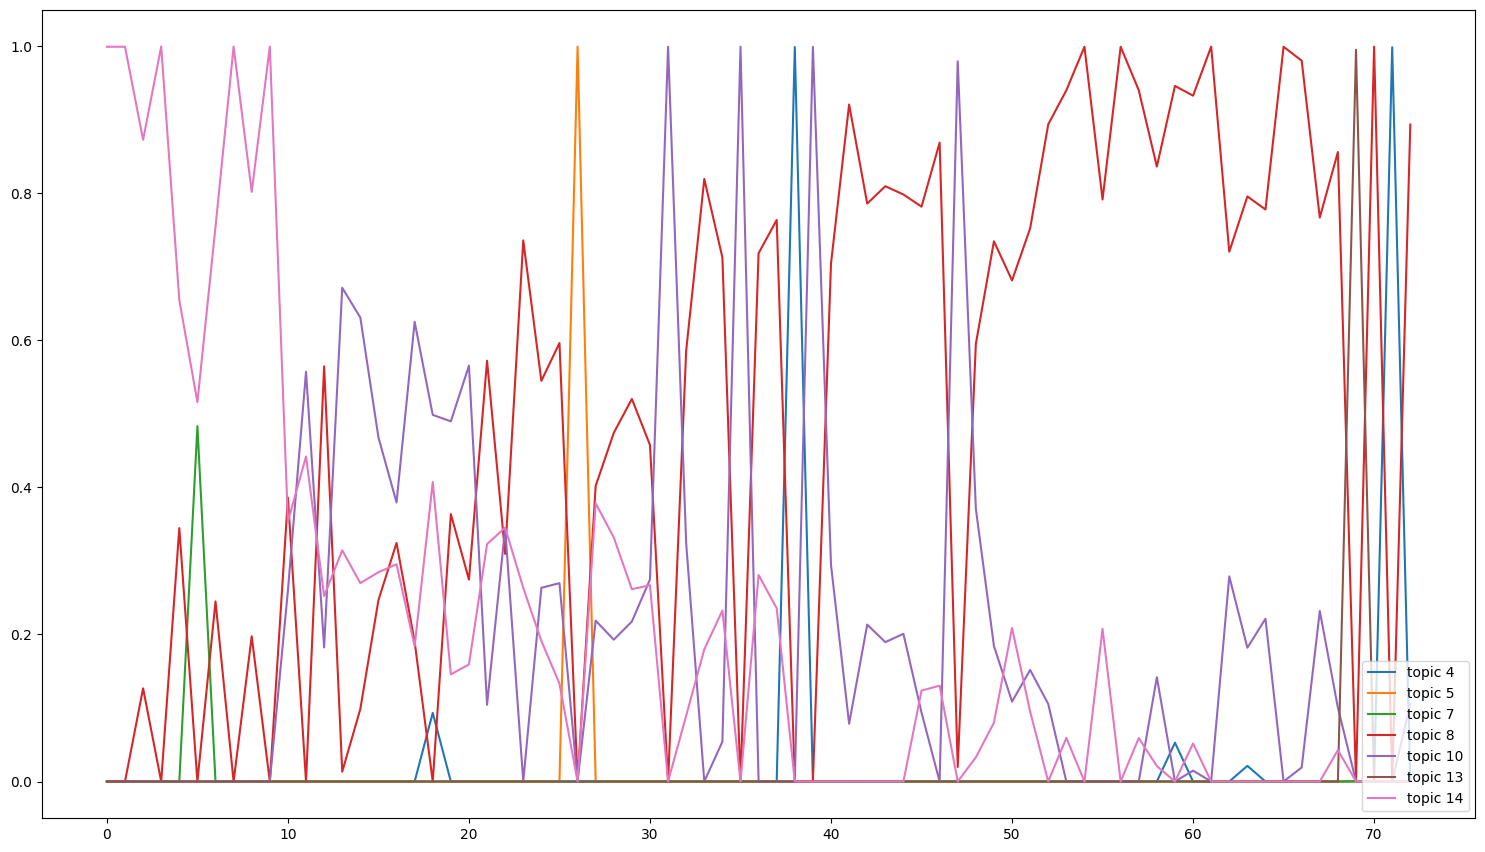

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

time = np.arange(len(dataset))
for i, topic_evolution in enumerate(np.transpose(lda_model.transform(matrix))):
    if(i not in major_topics): continue
    ax.plot(time, topic_evolution, label=f"topic {i}")

ax.legend(loc='lower right')
plt.show()

On représente ici le modèle LDA, en particulier les sujets inférés, à l'aide de la bibliothèque pyLDAvis (https://pyldavis.readthedocs.io/en/latest/readme.html).

L'interface est essentiellement composée d'un panneau gauche, organisant spatialement les différents sujets, et d'un panneau droit représentant la distribution sur le vocabulaire d'un sujet particulier.
Le panneau droit montre, pour un sujet sélectionné, les formes qui lui sont le plus « pertinentes ».
La notion de pertinence utilisée dépend d'un paramètre λ réglable et est décrite en bas du panneau.
Avec λ=1, les mots les plus pertinents sont ceux qui sont les plus fréquemment générés par ce sujet.
Avec λ=0, les mots les plus pertinents sont ceux qui sont les plus spécifiques à ce sujet.

Noter que la numération des sujets par cet outil n'est pas celle utilisée plus haut.
L'outil organise les sujets par importance décroissante dans le corpus, l'importance d'un sujet étant le nombre de tokens qu'il a généré (remarque : se rappeler le modèle génératif de la LDA).

In [31]:
try:
  import pyLDAvis
except:
  !pip install pyLDAvis
  #!pip install pyLDAvis==3.3.1
  import pyLDAvis

vis_data = pyLDAvis.prepare(topic_term_dists=topic_term_dists, doc_topic_dists=doc_topic_dists, doc_lengths=doc_lengths, vocab=id2form, term_frequency=term_frequency, mds='mmds') # https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.prepare
pyLDAvis.display(vis_data) # Warning: This tool numbers the topics according to their importance in the corpus (in term of number of tokens). It is possible to recognise a topic by looking at the list of forms displayed for λ=1. The list displayed for λ=0 shows the forms that are the most specific to the selected topic.

# Top2Vec

In [32]:
try:
  from top2vec import Top2Vec
except:
  !pip install top2vec
  from top2vec import Top2Vec

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Top2Vec ne fonctionne pas bien (le code peut même crasher) sur des petits ensembles de documents. C'est pourquoi le code suivant scinde chaque document en parties de moins de `max_tokens=500` tokens.

In [33]:
import itertools
import numpy as np

max_tokens = 250
documents = [" ".join(tokens) for tokens in itertools.chain(*[np.array_split(episode["processed_tokens"], np.ceil(len(episode["processed_tokens"])/max_tokens)) for episode in dataset])] # list[str]

print(f"from {len(dataset)} to {len(documents)} (shorter) documents")
print()

ids = [0, (len(documents)//2), -1]
for i in ids:
  print(f"Document n°{i}:")
  print(documents[i])
  print(f"(char len: {len(documents[i])})")
  print()

from 73 to 601 (shorter) documents

Document n°0:
doucement croyais sauvages vole chã vre ã autre finissent ã triper jamais vu sauvageons ã jamais rien vu tel vie approchã prã aussi prã possible devrions retourner mur morts font peur devions trouver sauvageons trouvã ennuieront demandera comment morts remonte selle tuã pourrait aussi tuer mãªme tuã enfants quelle chance ãªtre enfant fuir vers sud vas couperont tãªte comme ã dã serteur attrape avant remonte selle rã pã terai morts levã camp ã taient lã retrouve vas pã re regarde mã re aussi trã beau travail comme toujours fã licitations merci adore dã tails brodã coins magnifique points oh points trã trã joli merci lequel entre ã tait bon archer ã dix ans entraã bran vas rã flã chis trop bran relã che bras vite bran vite lord stark madame garde vient arriver collines capturã dã serteur garde nuit dis garã ons seller chevaux bien nã cessaire prãªtã serment cat loi loi madame dis ã brian venir ned dix ans trop jeune voir ã va finir grandi

## Entraînement du modèle

In [34]:
try:
  import torch
  gpu_available = (torch.cuda.device_count() > 0)
except:
  gpu_available = False

if(not gpu_available): print("No GPU available. Neural computations might be very slow. You might be able to make a GPU available by changing the notebook's settings.")
else: print("GPU available.")

No GPU available. Neural computations might be very slow. You might be able to make a GPU available by changing the notebook's settings.


In [35]:
top2vec_model = Top2Vec(documents=documents, ngram_vocab=False, contextual_top2vec=False) # https://top2vec.readthedocs.io/en/latest/api.html#top2vec.top2vec.Top2Vec

2025-01-24 19:52:11,604 - top2vec - INFO - Pre-processing documents for training


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-01-24 19:52:12,753 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Maxime\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate

## Analyse

Garder à l'esprit que Top2Vec tend à ne donner des résultats intéressants que quand les sujets ne sont pas trop mélangés au sein de chaque document. Ça marche par exemple très bien avec le jeu de données artificiel.

In [36]:
num_topics = top2vec_model.get_num_topics()
print(f"{num_topics} topics induced.")

print()
topic_words, word_scores, topic_nums = top2vec_model.get_topics(num_topics)
for i in topic_nums:
  print("Top 50 vocabulary item in terms of semantic similarity to the topic n°{i}:")
  print(list(zip(topic_words[i], word_scores[i])))

2 topics induced.

Top 50 vocabulary item in terms of semantic similarity to the topic n°{i}:
[('pensais', 0.4448866), ('seigneurs', 0.4353717), ('contre', 0.4254178), ('connaissez', 0.40656206), ('laisse', 0.39977965), ('faites', 0.3983086), ('voir', 0.39685947), ('connais', 0.38746524), ('devoir', 0.3840838), ('pense', 0.3833579), ('vieux', 0.37669268), ('vois', 0.37042177), ('fais', 0.36873996), ('seulement', 0.36693358), ('entre', 0.3643475), ('quelle', 0.36266115), ('meilleur', 0.36172986), ('parce', 0.3615479), ('seigneur', 0.36142358), ('demande', 0.35774094), ('quelques', 0.35540932), ('merci', 0.354693), ('voici', 0.35276106), ('taªte', 0.35185453), ('honneur', 0.35180762), ('vraiment', 0.34707996), ('rement', 0.3465712), ('regarde', 0.34636733), ('vite', 0.34232974), ('fois', 0.33854246), ('cadeau', 0.33741367), ('trouva', 0.33738554), ('vient', 0.33676878), ('trouve', 0.33651626), ('jure', 0.33628297), ('aªtre', 0.3341588), ('parle', 0.3329436), ('pourrait', 0.33213085), ('c

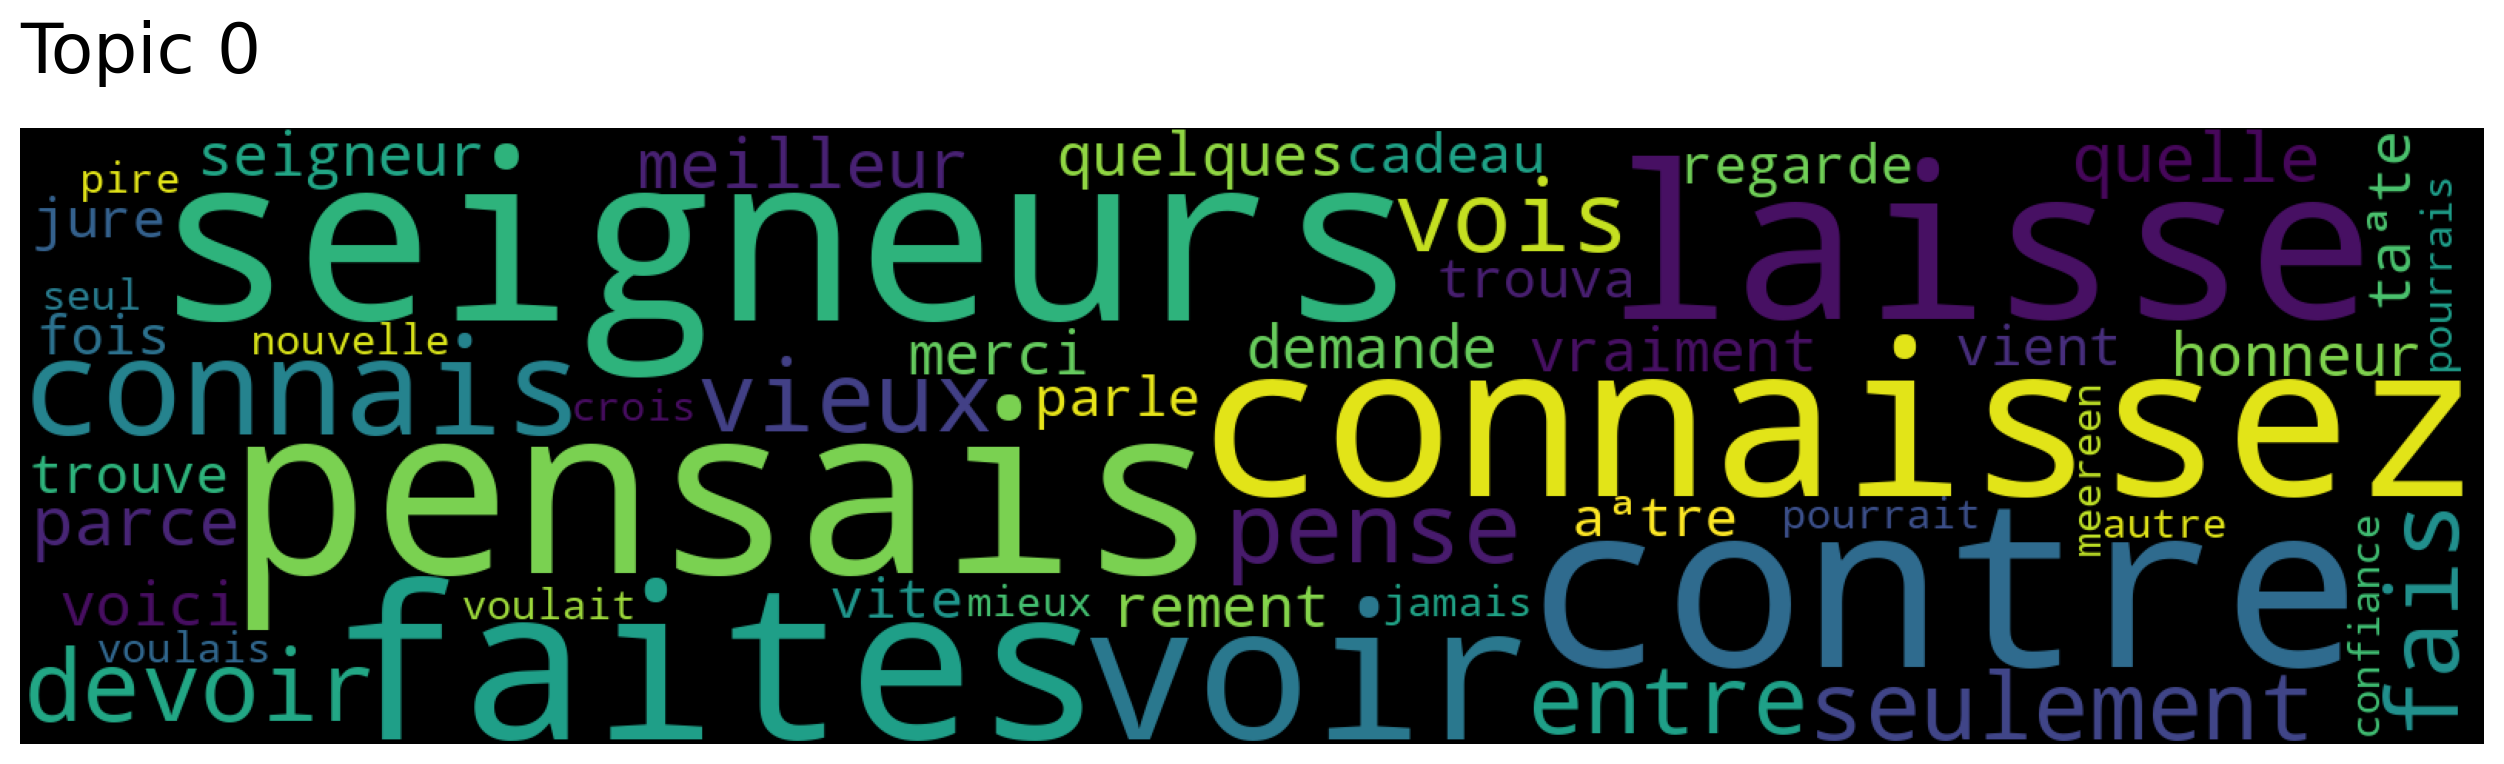

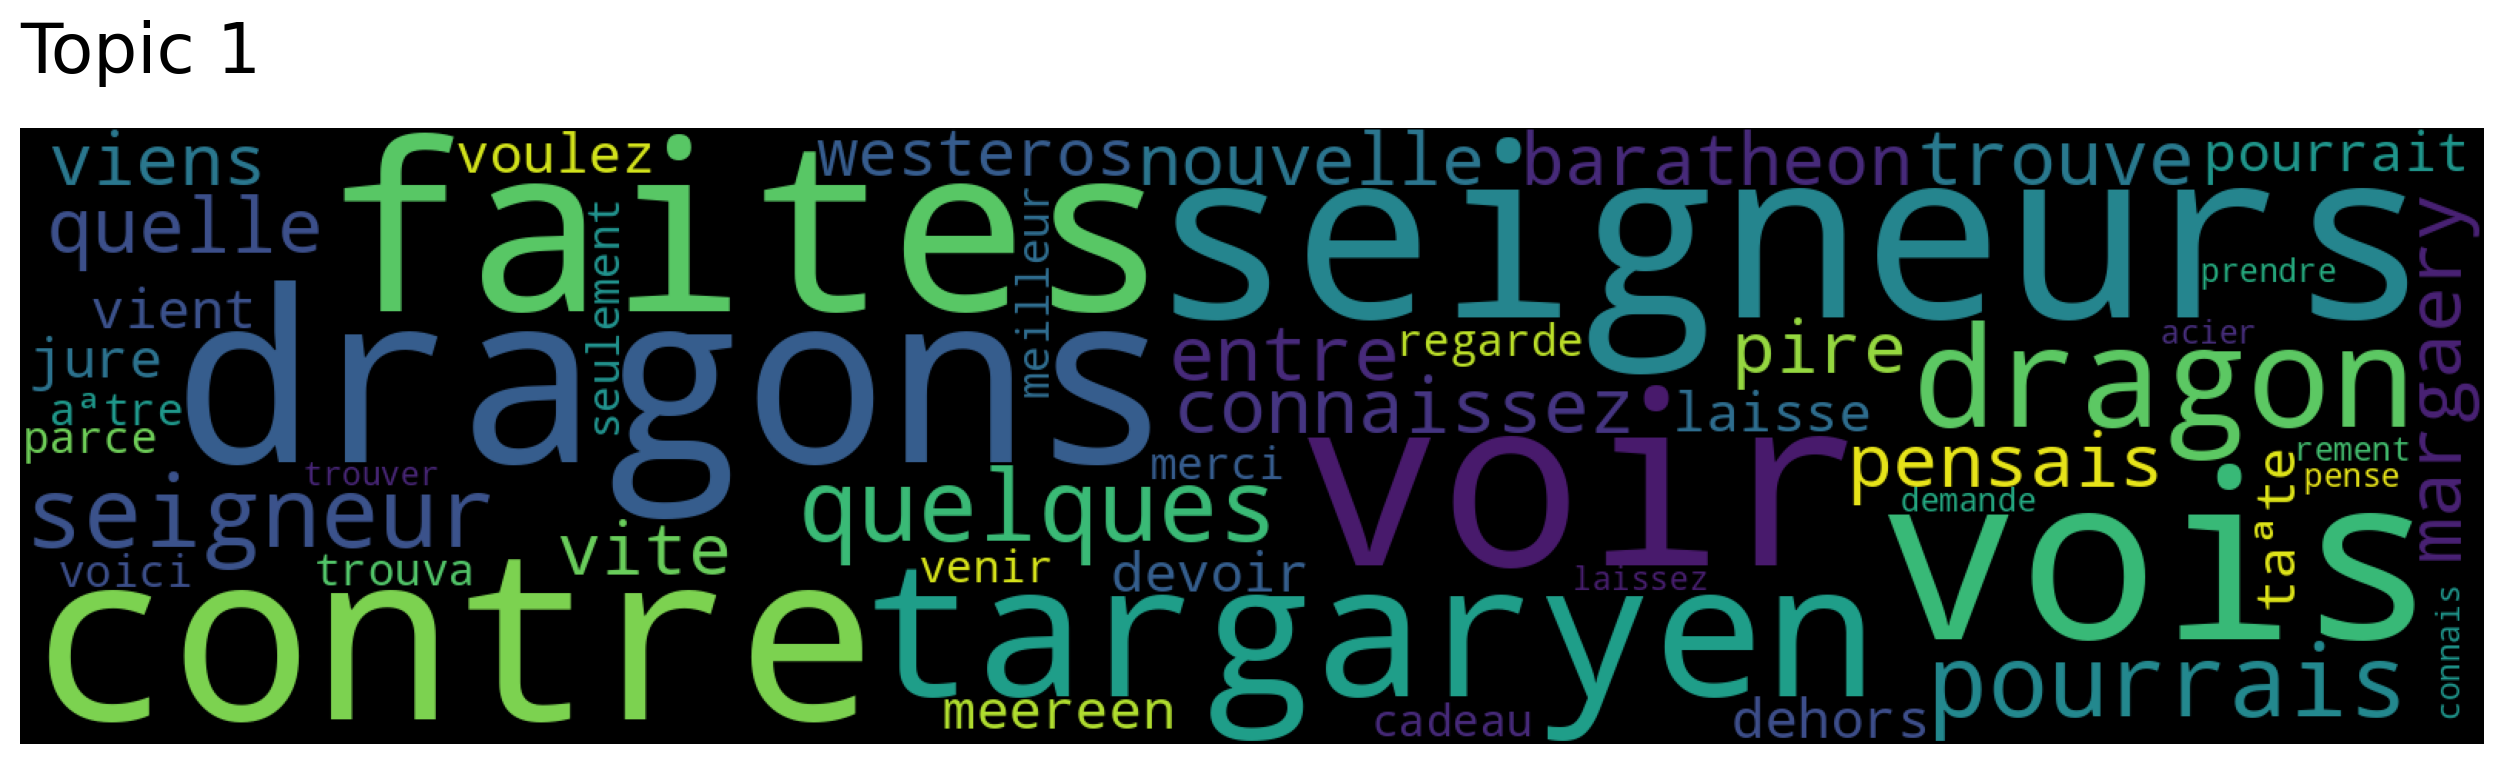

In [37]:
for i in topic_nums:
  top2vec_model.generate_topic_wordcloud(i)

La bibliothèque Top2Vec propose d'autres fonctionnalités.
Plus d'information :
*  sur la page GitHub de Top2Vec, https://github.com/ddangelov/Top2Vec
*  dans la documentation de Top2Vec, https://top2vec.readthedocs.io

Voir aussi les (pré)publications scientifiques :
*   Angelov, Dimo. « Top2Vec: Distributed Representations of Topics ». arXiv, 19 août 2020. https://doi.org/10.48550/arXiv.2008.09470.
*   Angelov, Dimo, et Diana Inkpen. « Topic Modeling: Contextual Token Embeddings Are All You Need ». In Findings of the Association for Computational Linguistics: EMNLP 2024, édité par Yaser Al-Onaizan, Mohit Bansal, et Yun-Nung Chen, 13528‑39. Miami, Florida, USA: Association for Computational Linguistics, 2024. https://doi.org/10.18653/v1/2024.findings-emnlp.790.
